## Generating the pdf

First up let's see how our pdf looks compared to SciPy and how quickly we can generate those pdf numbers in comparison.

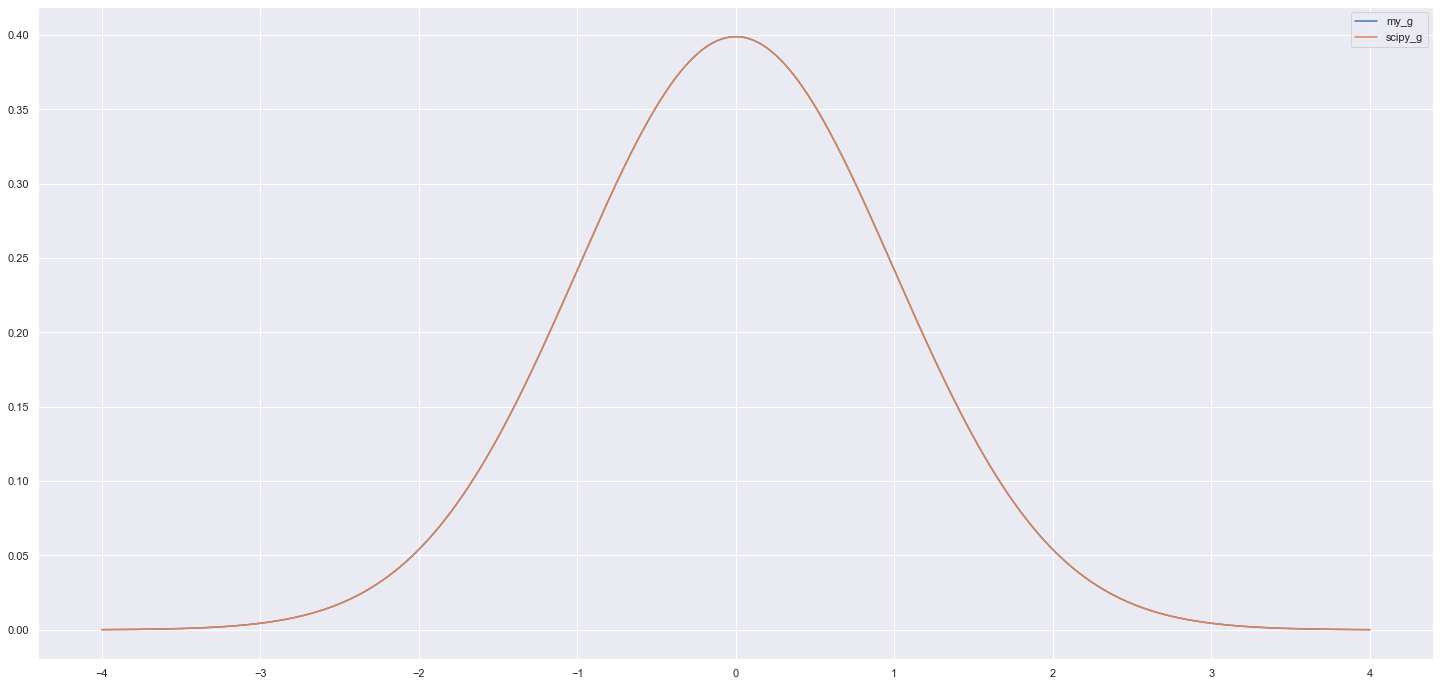

In [570]:
# init our new dist
my_g = my_gaussian(name='my_g')
# init the built in scipy method
scipy_g = stats.norm(loc=0, scale=1)

# create x's
xs = np.linspace(-4.0, 4.0, 10000)
# get both distribution pdf numbers
my_g_pdf = [my_g.pdf(x) for x in xs]
scipy_g_pdf = [scipy_g.pdf(x) for x in xs]

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

ax.plot(xs, my_g_pdf, label='my_g')
ax.plot(xs, scipy_g_pdf, label='scipy_g')
ax.legend();

Okay so we are looking bang on for the pdf numbers that we generate. This shouldn't come as much of a surprise - it is an analytical formula with not much room for error. Now let's have a look at timings.

In [571]:
%timeit [my_g.pdf(x) for x in xs]

2.84 s ± 480 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [574]:
%timeit [scipy_g.pdf(x) for x in xs]

2.26 s ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So we're slightly slower than SciPy but not by that much. Now let's have a look at generating numbers from the cdf.

## Generating the cdf

Let's do the exact same as before and compare.

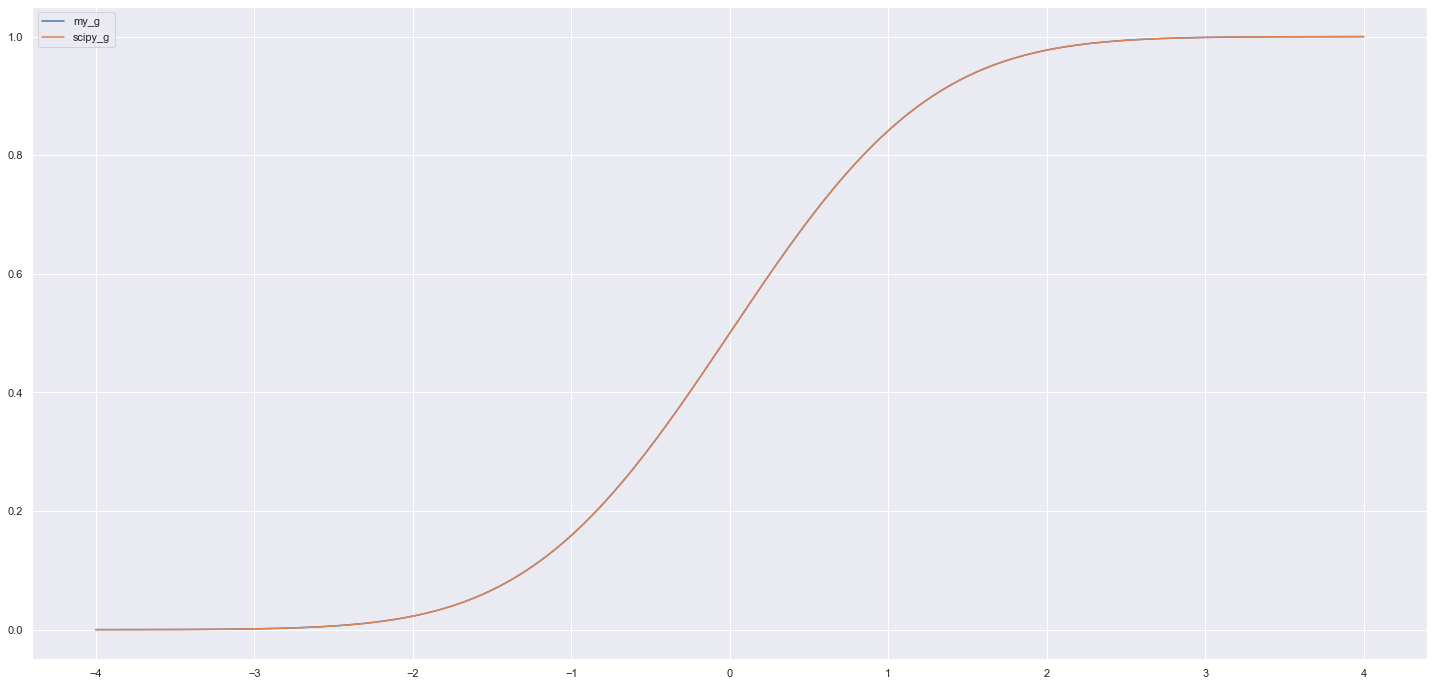

In [577]:
# create x's
xs = np.linspace(-4.0, 4.0, 10000)
# get both distribution pdf numbers
my_g_cdf = [my_g.cdf(x) for x in xs]
scipy_g_cdf = [scipy_g.cdf(x) for x in xs]

# plot them
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

ax.plot(xs, my_g_cdf, label='my_g')
ax.plot(xs, scipy_g_cdf, label='scipy_g')
ax.legend();

Again, we seem to be accurate. How do we compare for timing?

In [578]:
%timeit [my_g.cdf(x) for x in xs]

7.83 s ± 322 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [579]:
%timeit [scipy_g.cdf(x) for x in xs]

2.09 s ± 59.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Oh dear. We're really starting to slow down. We've gone from being around 25% slower than SciPy to being almost 4x slower. It's worth highlighting here that we haven't even specified a `cdf` method in our `my_gaussian` class so SciPy must be doing something clever under the hood to infer it from our specified `pdf` method.

Now let's see how we fare when we generate samples from our distribution.

## Generating samples

One last time - how does our distribution fare when it comes to sampling from it?

In [1]:
# usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import warnings

# some config
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')
sns.set() 

Let's first create our own version of a gaussian distribution. This means we can always check it vs the scipy version for:
 - accuracy
 - speed

In [519]:
n = 1000

In [520]:
class my_gaussian(stats.rv_continuous):
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)

In [532]:
my_g = my_gaussian(name='my_g')
scipy_g = stats.norm(loc=0, scale=1)

In [522]:
my_sample = my_g.rvs(size=n)

In [523]:
%timeit my_sample = my_g.rvs(loc=0, scale=1, size=n)

13.8 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [524]:
scipy_sample = scipy_g.rvs(size=n)

In [525]:
%timeit scipy_sample = scipy_g.rvs(size=n)

142 µs ± 31.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


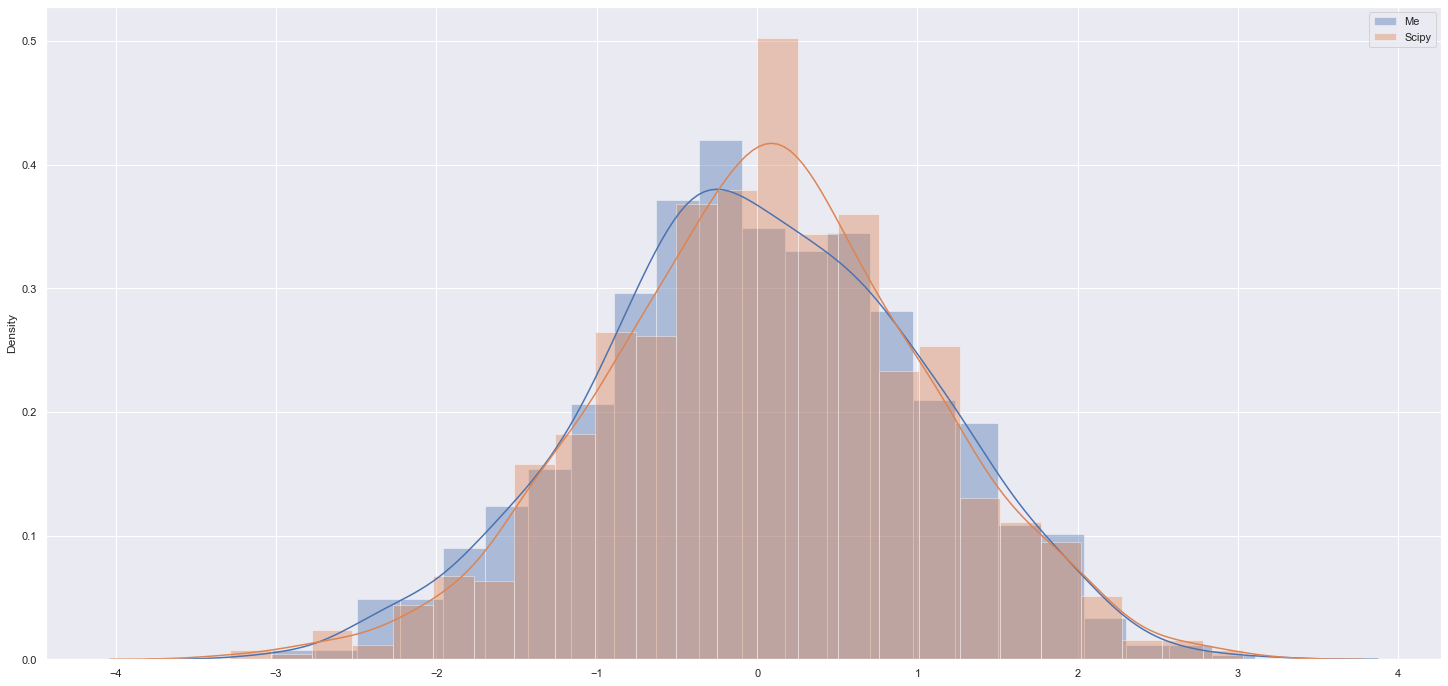

In [526]:
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(my_sample, ax=ax, kde=True, label='Me')
sns.distplot(scipy_sample, ax=ax, kde=True, label='Scipy')
ax.legend();

So it seems like even though we are getting similar distributions (with only `1,000` samples our own version is ludicriously slow - `13.8s` to generate `1,000` samples. We need to somehow improve this.

In [535]:
from scipy.stats._continuous_distns import _norm_cdf

In [533]:
?? stats.norm._cdf

Signature:  stats.norm._cdf(x)
Docstring: <no docstring>
Source:   
    def _cdf(self, x):
        return _norm_cdf(x)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py
Type:      method


In [550]:
class my_gaussian(stats.rv_continuous):
    def _pdf(self, x):
        return np.exp(-x**2 / 2.) / np.sqrt(2.0 * np.pi)
    # def _cdf(self, x):
    #     return _norm_cdf(x)

In [551]:
my_g = my_gaussian(name='my_g')
scipy_g = stats.norm(loc=0, scale=1)

In [538]:
my_sample = my_g.rvs(size=n)

In [539]:
%timeit my_sample = my_g.rvs(loc=0, scale=1, size=n)

3.4 s ± 326 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


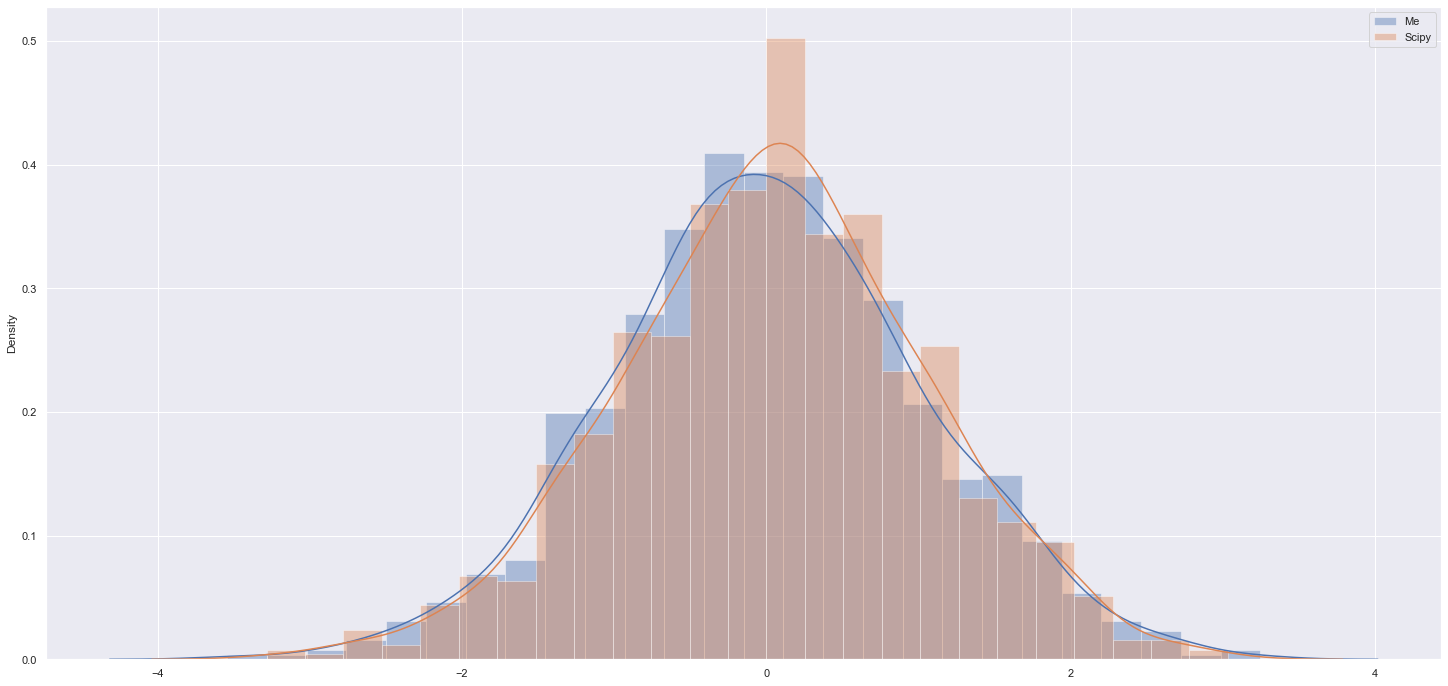

In [540]:
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(my_sample, ax=ax, kde=True, label='Me')
sns.distplot(scipy_sample, ax=ax, kde=True, label='Scipy')
ax.legend();

So we seem to have clawed back some time by defining our own `_cdf` method but I'm not really sure why - let's look into what happens when we call `rvs`.

In [552]:
?? my_g._rvs

Signature:  my_g._rvs(*args, size=None, random_state=None)
Docstring: <no docstring>
Source:   
    def _rvs(self, *args, size=None, random_state=None):
        # This method must handle size being a tuple, and it must
        # properly broadcast *args and size.  size might be
        # an empty tuple, which means a scalar random variate is to be
        # generated.

        # Use basic inverse cdf algorithm for RV generation as default.
        U = random_state.uniform(size=size)
        Y = self._ppf(U, *args)
        return Y
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


So it seems like we use inverse transform sampling of some kind as we:
 - generate a uniform random variable of desired size
 - feed that into the `_ppf` function which I'm guessing does some kind of inverse cdf
 - this is verified by the notes stating _"# Use basic inverse cdf algorithm for RV generation as default."_

Let's now dig into this `_ppf` function and see if at any point if this makes reference to our defined `_cdf` function.

In [553]:
?? my_g._ppf

Signature:  my_g._ppf(q, *args)
Docstring: <no docstring>
Source:   
    def _ppf(self, q, *args):
        return self._ppfvec(q, *args)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [554]:
?? my_g._ppf_single

Signature:  my_g._ppf_single(q, *args)
Docstring: <no docstring>
Source:   
    def _ppf_single(self, q, *args):
        factor = 10.
        left, right = self._get_support(*args)

        if np.isinf(left):
            left = min(-factor, right)
            while self._ppf_to_solve(left, q, *args) > 0.:
                left, right = left * factor, left
            # left is now such that cdf(left) <= q
            # if right has changed, then cdf(right) > q

        if np.isinf(right):
            right = max(factor, left)
            while self._ppf_to_solve(right, q, *args) < 0.:
                left, right = right, right * factor
            # right is now such that cdf(right) >= q

        return optimize.brentq(self._ppf_to_solve,
                               left, right, args=(q,)+args, xtol=self.xtol)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [555]:
?? my_g._ppf_to_solve

Signature:  my_g._ppf_to_solve(x, q, *args)
Docstring: <no docstring>
Source:   
    def _ppf_to_solve(self, x, q, *args):
        return self.cdf(*(x, )+args)-q
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [556]:
?? my_g._cdf

Signature:  my_g._cdf(x, *args)
Docstring: <no docstring>
Source:   
    def _cdf(self, x, *args):
        return self._cdfvec(x, *args)
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


In [558]:
?? my_g._cdf_single

Signature:  my_g._cdf_single(x, *args)
Docstring: <no docstring>
Source:   
    def _cdf_single(self, x, *args):
        _a, _b = self._get_support(*args)
        return integrate.quad(self._pdf, _a, x, args=args)[0]
File:      ~/dev/opcoes/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method


## What are we trying to achieve?

We want to generate distributions that have the same variance but have varying degrees of fat-tailedness. To do this we want to use Jensen's inequality whereby we can use the average of two Gaussians with different variances to create a variance preserving transform - we'll have a resulting distribution with the same variance as a standard normal but with more kurtosis.

## What's so hard about that?

Sampling from a distribution isn't just the simple task I always thought it was in school. I thought that if you could write the pdf then you could draw samples from it. If it's a bell curve then just pick more samples in the middle and fewer in the tails. It turns out efficienctly doing this is quite a challenge.

## What do we do fo the Normal Distribution?

It turns out even for the normal distribution this is quite a challenge. We use something called the Ziggurat Algorithm to generate samples. This is because unlike other distributions (like the exponential distribution) it is impossible to invert the Normal Distribution CDF.

## Why does this matter?

Because the standard way of sampling is called 'Inverse Transform Sampling' and relies on the result that every distribution's CDF is uniformly distributed. That means that you can go in the reverse - start with a uniform distribution (which we can generate easily) and fire those samples at the _inverse_ CDF to generate samples from that distribution. If you can't invert the cdf, you can't do tat easily, accuractely and efficiently.

## So how have they solved this?

There have been many ways. One first one is a to approximate the inverse CDF with a large polynomial function - however this performs poorly in the tails of the distribution as that is where a Normal CDF is curvy and so even with many polynomial terms we fail to represent it correctly.

Another one is acceptance-rejection sampling and this is still one that is widely used today.

## So what are we trying to solve?

We know that we want to sample numbers that are from a distribution that is the average of two normal distributions - each one with a variance slighltly perturbed around the standard normal variance of `1`. In other words our chosen pdf looks like this:

$$
\begin{align}
f(x; \mu, \sigma, \epsilon) &= \frac{1}{2} [\phi(x | \mu, \sigma - \epsilon) + \phi(x | \mu, \sigma + \epsilon)] \\
                            &= \frac{1}{2} [\frac{1}{[\sigma - \epsilon] \sqrt{2 \pi}} e^{-\frac{1}{2} \frac{(x - \mu)^2}{[\sigma - \epsilon]^2}} + \frac{1}{[\sigma + \epsilon] \sqrt{2 \pi}} e^{-\frac{1}{2} \frac{(x - \mu)^2}{[\sigma + \epsilon]^2}}] \\
\end{align}
$$

Now let's define our pdf alongside that of a 'normal Normal':

In [316]:
from scipy.integrate import simps
from scipy.interpolate import interp1d

In [414]:
# this is the 1d domain over which our pdf exists
xs = np.linspace(-4.0, 4.0, 10000)

# define normal pdd
def norm_p(x, mu=0, sigma=1):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-0.5 * ((x - mu)**2 / sigma**2))

# define our pdf
def p(x, mu=0, sigma=1, sigma_dev=0):
    low = norm_p(x, mu, sigma * (1 - sigma_dev)**0.5)
    high = norm_p(x, mu, sigma * (1 + sigma_dev)**0.5)
    return 0.5 * (low + high)

# define function to normalise the PDF over chosen domain
def normalisation(x):
	return simps(p(x), x)

In [415]:
# define the distribution using rv_continuous
class mixnorm(stats.rv_continuous): 
    def _pdf(self, x, const):
        return (1.0 / const) * p(x, sigma_dev = 0.5)

In [416]:
mix_norm = mixnorm(name="mix_norm")

# Find the normalisation constant first
norm_constant = normalisation(xs)

# create pdf, cdf, random samples
pdf = mix_norm.pdf(x = xs, const = norm_constant)
cdf = mix_norm.cdf(x = xs, const = norm_constant)

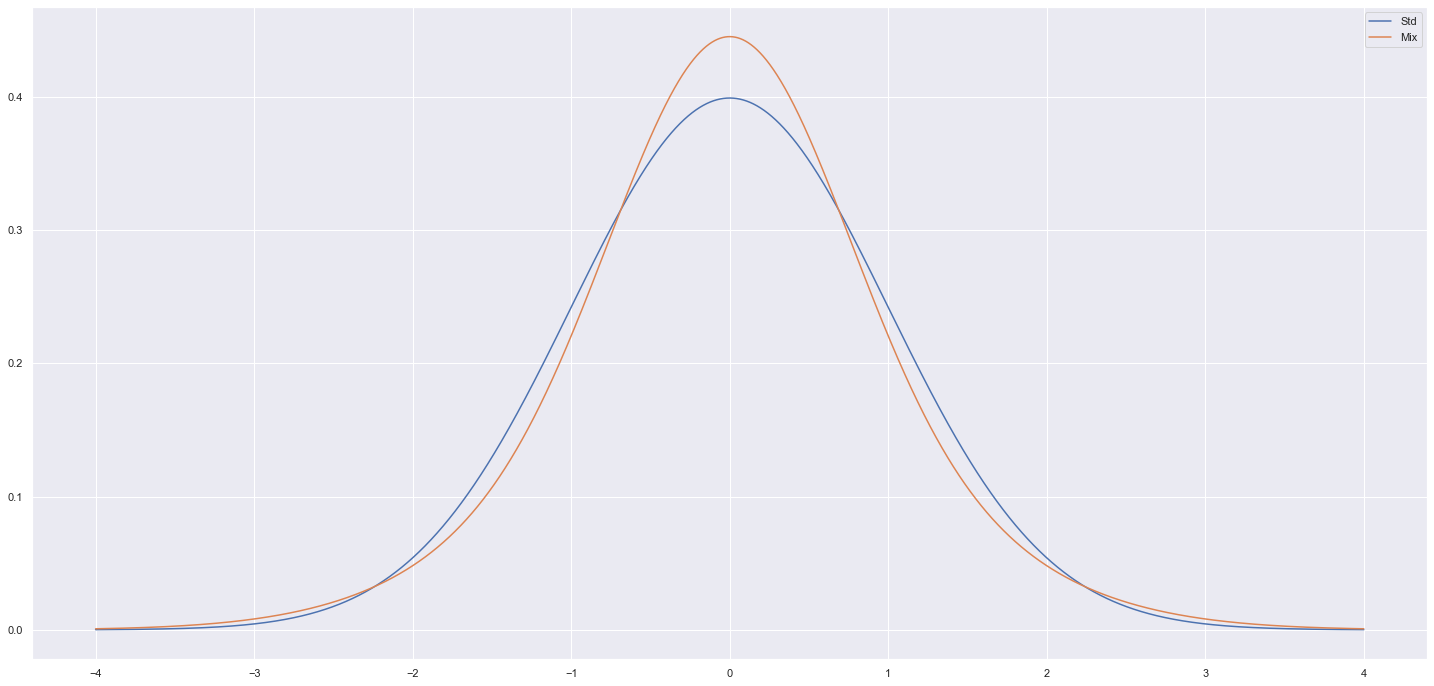

In [417]:
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

ax.plot(xs, [stats.norm.pdf(x) for x in xs], label='Std')
ax.plot(xs, pdf, label='Mix')
ax.legend();

In [418]:
samples = mix_norm.rvs(const = norm_constant, size = 1000)

In [419]:
np.var(samples)

0.9767189112891272

In [420]:
np.var(stats.norm.rvs(size=1000))

1.0703469768738882

In [428]:
# this is the 1d domain over which our pdf exists
xs = np.linspace(-10.0, 10.0, 100000)

# define normal pdd
def norm_p(x, mu=0, sigma=1):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-0.5 * ((x - mu)**2 / sigma**2))

# define our pdf
def p(x, mu=0, sigma=1, sigma_dev=0):
    low = norm_p(x, mu, sigma * (1 - sigma_dev)**0.5)
    high = norm_p(x, mu, sigma * (1 + sigma_dev)**0.5)
    return 0.5 * (low + high)

# define function to normalise the PDF over chosen domain
def normalisation(x):
	return simps(p(x), x)

# define function to normalise our pdf to sum to 1 so it satisfies a distribution
norm_constant = normalisation(xs)

# our own pdf, cdf and samples
own_pdf = p(xs, sigma_dev=0.5) / norm_constant
own_cdf = np.cumsum(own_pdf)
own_cdf /= max(own_cdf)

# define a function to return N samples
def gen_samples(N):
	u = np.random.uniform(0, 1, int(N))
	func_interp = interp1d(own_cdf, xs)
	samples = func_interp(u)
	return samples

In [429]:
n = 100000
norm_samples = stats.norm.rvs(size=n)
own_samples = gen_samples(n)

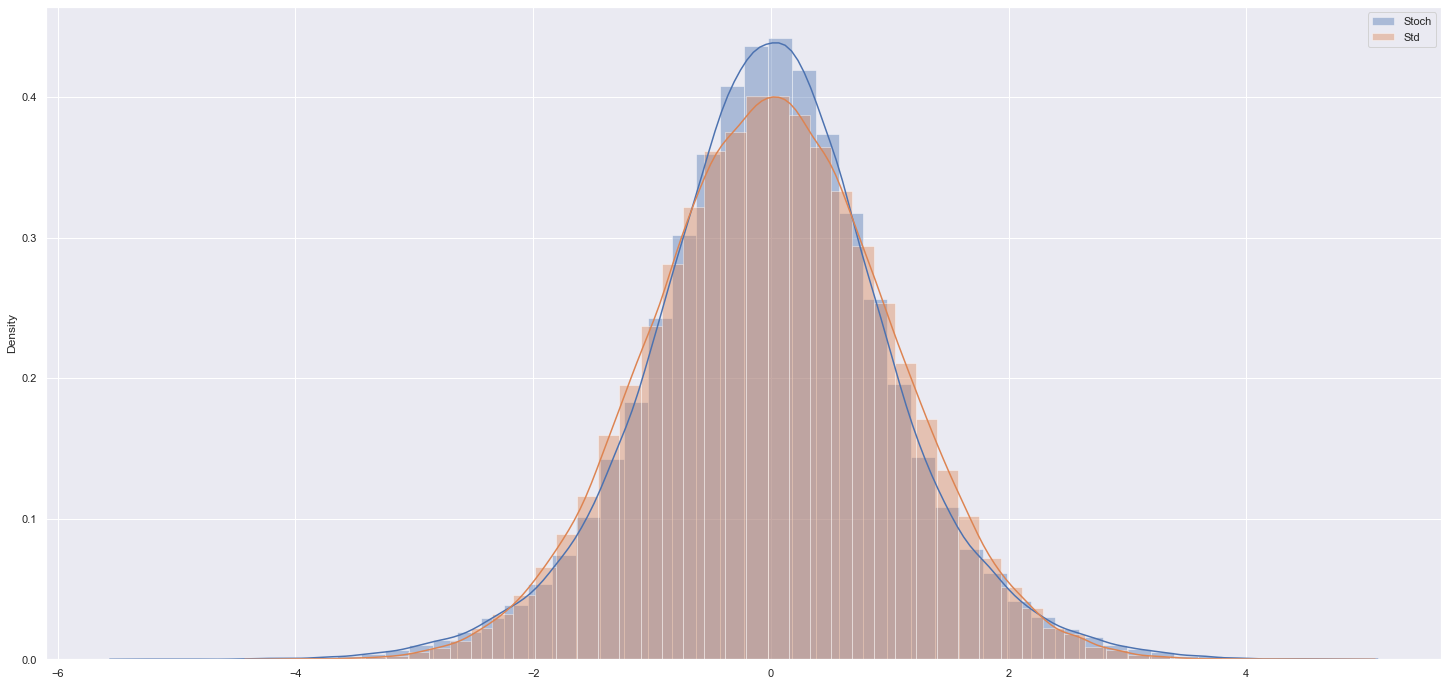

In [430]:
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(own_samples, ax=ax, kde=True, label='Stoch')
sns.distplot(norm_samples, ax=ax, kde=True, label='Std')
ax.legend();

In [440]:
np.var(own_samples)

0.19907045034415952

In [441]:
np.var(norm_samples)

1.00166887991189

In [501]:
# this is the 1d domain over which our pdf exists
xs = np.linspace(-10.0, 10.0, 100000)

# define normal pdd
def norm_p(x, mu=0, sigma=1):
    return (1 / (sigma * (2 * np.pi)**0.5)) * np.exp(-0.5 * ((x - mu)**2 / sigma**2))

# define our pdf
def p(x, mu=0, sigma=1):
    
    rng = np.random.default_rng(seed=123)
    p = 0.5
    a = 0.8
    b = -a * (p / (1-p))
    return p * norm_p(x, mu, sigma * (1 + a)**0.5) + (1-p) * norm_p(x, mu, sigma * (1 + b)**0.5)
    # return norm_p(x, mu, (sigma * (1 + rng.choice([a, b], p=[p, 1-p])))**0.5)

# define function to normalise the PDF over chosen domain
def normalisation(x):
	return simps(p(x), x)

# define function to normalise our pdf to sum to 1 so it satisfies a distribution
norm_constant = normalisation(xs)

# our own pdf, cdf and samples
own_pdf = p(xs) / norm_constant
own_cdf = np.cumsum(own_pdf)
own_cdf /= max(own_cdf)

# define a function to return N samples
def gen_samples(N):
	u = np.random.uniform(0, 1, int(N))
	func_interp = interp1d(own_cdf, xs)
	samples = func_interp(u)
	return samples

In [502]:
n = 100000
norm_samples = stats.norm.rvs(size=n)
own_samples = gen_samples(n)

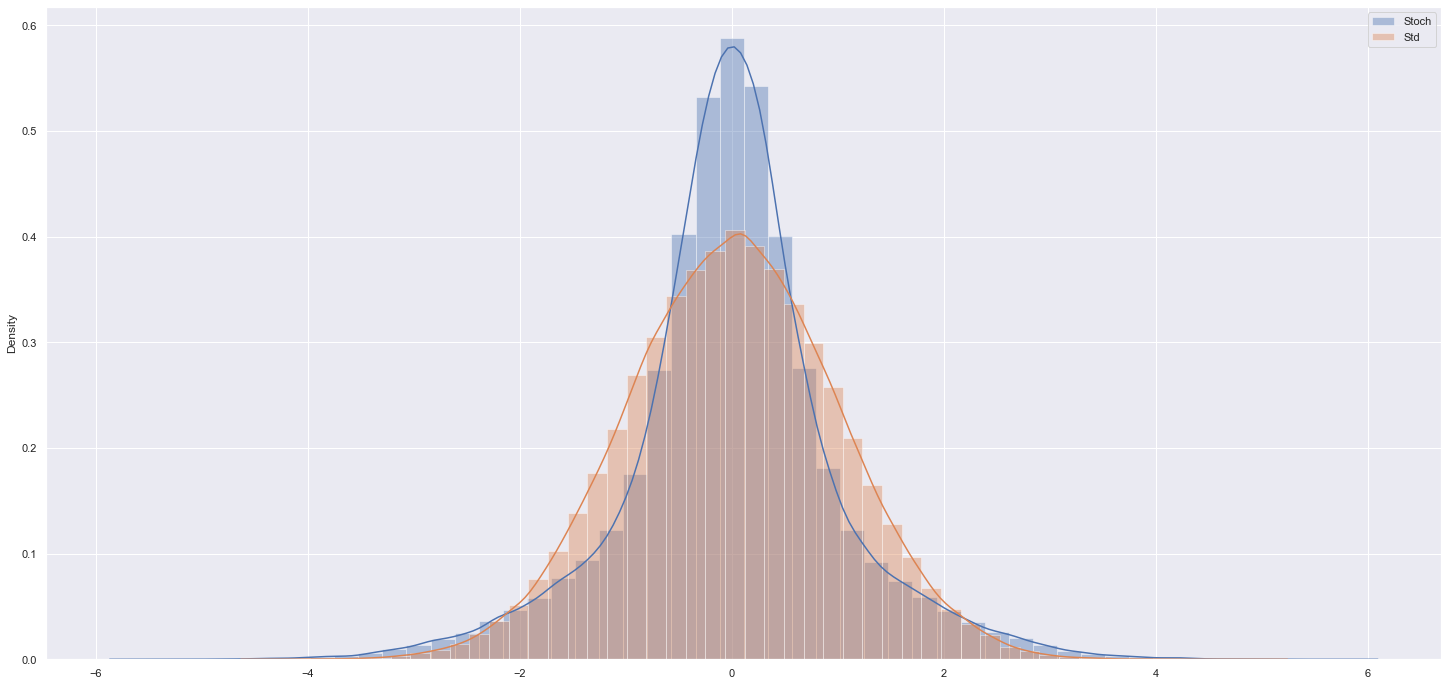

In [503]:
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(own_samples, ax=ax, kde=True, label='Stoch')
sns.distplot(norm_samples, ax=ax, kde=True, label='Std')
ax.legend();

In [504]:
np.var(own_samples)

0.9932342991928732

In [505]:
np.var(norm_samples)

1.0010444286679336

In [506]:
stats.kurtosis(own_samples)

1.8645765073274854

In [507]:
stats.kurtosis(norm_samples)

-0.009983399550883565

In [566]:
np.mean([max(x, 0) for x in own_samples])

0.3556595017009501

In [567]:
np.mean([max(x, 0) for x in norm_samples])

0.4013459921040744

In [ ]:
def generate_paths_custom(spot, drift, sigma, years, points, sims, dist=None):
    
    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    dW = rng.normal(size=(sims, int(points * years)))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    # return the goodies
    return daily_devs, pxs

In [235]:
mix = mix_norm(name='mix_norm')

In [240]:
x = mix.rvs(size=10)

In [241]:
x

array([-0.52560889, -0.43049554, -1.66492022,  0.46765673, -0.79038876,
        1.19364552,  1.67895783, -1.5739257 ,  0.05469355, -1.79835966])

In [198]:
def generate_paths(spot, drift, sigma, years, points, sims, sigma_dev=0):

    # create numpy PCG PRNG
    rng = np.random.default_rng(seed=123)
    # create random numbers
    if sigma_dev != 0:
        upper_devs = rng.normal(size=(sims, int(points * years)), scale=1 + sigma_dev)
        lower_devs = rng.normal(size=(sims, int(points * years)), scale=1 - sigma_dev)
        dW = np.mean([lower_devs, upper_devs], axis=0)
    else:
        dW = rng.normal(size=(sims, int(points * years)))
    # get our scaled random deviations
    scaled_dW = dW * (sigma / points**0.5)
    # add on the drift
    daily_devs = (drift / points) + scaled_dW
    # cumsum them as log returns additive
    cum_rets = np.cumsum(daily_devs, axis=1)
    # add in 0 at start for starting price
    cum_rets = np.insert(cum_rets, 0, 0, axis=1)
    # create price series
    pxs = spot * np.exp(cum_rets)
    # return the goodies
    return daily_devs, pxs

In [243]:
def rejection_sampler(p,xbounds,pmax):
    while True:
        x = np.random.rand(1)*(xbounds[1]-xbounds[0])+xbounds[0]
        y = np.random.rand(1)*pmax
        if y<=p(x):
            return x

In [242]:
def mix_pdf(loc, scale, scale_dev):
    return 0.5 * (stats.norm.pdf(x, loc=loc, scale=1 - scale_dev) + stats.norm.pdf(x, loc=loc, scale=1 + scale_dev))

In [199]:
spot = 100
drift = 0.00
sigma = 0.20
years = 1
points = 252
sims = 10000
sigma_dev = 0.01

In [215]:
rets, pxs = generate_paths(spot, drift, sigma, years, points, sims, sigma_dev=0)
rets_v, pxs_v = generate_paths(spot, drift, sigma, years, points, sims, sigma_dev=0.000001)
rets_v2, pxs_v2 = generate_paths(spot, drift, sigma, years, points, sims, sigma_dev=0.05)

In [216]:
log_rets = np.log(pxs[:, -1] / pxs[:, 0])
log_rets_v = np.log(pxs_v[:, -1] / pxs_v[:, 0])
log_rets_v2 = np.log(pxs_v2[:, -1] / pxs_v2[:, 0])

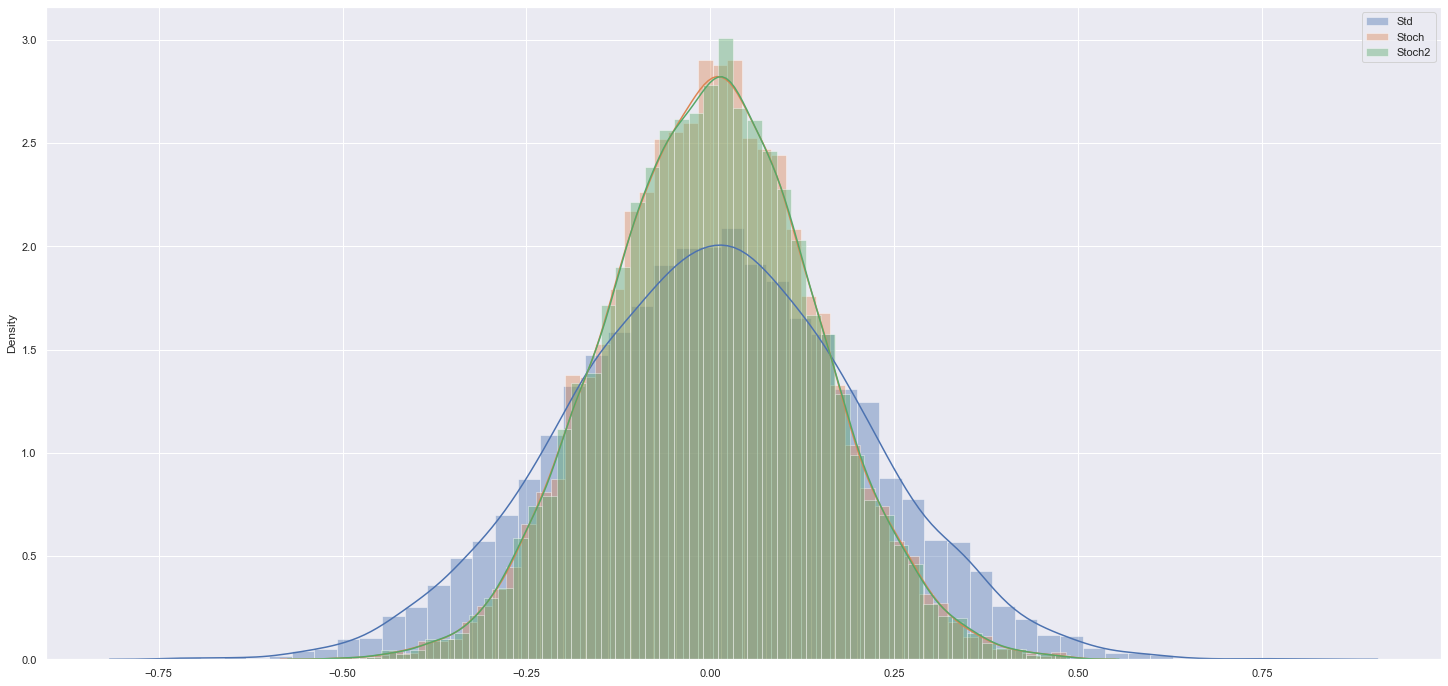

In [217]:
fig, ax = plt.subplots(ncols=1, figsize=(25,12))

sns.distplot(log_rets, ax=ax, kde=True, label='Std')
sns.distplot(log_rets_v, ax=ax, kde=True, label='Stoch')
sns.distplot(log_rets_v2, ax=ax, kde=True, label='Stoch2')
ax.legend();

In [203]:
stats.norm.fit(log_rets, floc=0)

(0, 0.19774439111735592)

In [204]:
stats.norm.fit(log_rets_v, floc=0)

(0, 0.14161242576656907)

In [205]:
stats.norm.fit(log_rets_v2, floc=0)

(0, 0.14206742995008326)

In [206]:
np.var(log_rets)

0.03908576684128841

In [207]:
np.var(log_rets_v)

0.0200512489645693

In [208]:
np.var(log_rets_v2)

0.020179873967288573

In [187]:
np.mean([max(x - 100, 0) for x in pxs[:, -1]])

9.224951049296637

In [188]:
np.mean([max(x - 100, 0) for x in pxs_v[:, -1]])

6.284933489305516

In [189]:
np.mean([max(x - 100, 0) for x in pxs_v2[:, -1]])

6.314928813614717